<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
"""
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])
"""
# custom note: it's not necessary to install piplite within jupyter lab
# custom note: modules not used within jupyter lab

"\nimport piplite\nawait piplite.install(['numpy'])\nawait piplite.install(['pandas'])\nawait piplite.install(['seaborn'])\n"

We will import the following libraries for the lab


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# np.random.seed(0)    # custom

# Pandas is a software library written for the Python programming language for data manipulation and analysis.
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
# Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
# Preprocessing allows us to standarsize our data
# Allows us to split our data into training and testing data
# Allows us to test parameters of classification algorithms and find the best one
# Logistic Regression classification algorithm
# Support Vector Machine classification algorithm
# Decision Tree classification algorithm
# K Nearest Neighbors classification algorithm

This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict,name): # custom: name
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); # annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix {name}'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    
    filename=f's__-4_1-{name}.png' # custom
    plt.savefig(filename, bbox_inches='tight', dpi = 100, transparent=True) # custom
    
    plt.show() 

## Load the dataframe


Load the data


In [4]:
"""
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

"""

# custom code (within jupyter lab, replacing the code above)
# URL1 = 'dataset_part_2.csv'    # use 'dataset_part_2.csv' file previously downloaded to root path, if necessary
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"

data = pd.read_csv(URL1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
"""
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

"""

# custom code (within jupyter lab, replacing the code above)
# URL2 = 'dataset_part_3.csv'    # use 'dataset_part_3.csv' file previously downloaded to root path, if necessary
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'

X = pd.read_csv(URL2)

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [8]:
Y = data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [9]:
# students get this
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
X

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -8.35531692e-01, -5.17306132e-01,  5.17306132e-01]])

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=2
)

In [11]:
# custom cell
print(f'Shape:\n \
        Data   (100%): {data.shape}\n\n \
        X_train (80%): {X_train.shape}\n \
        Y_train (80%): {Y_train.shape}\n\n \
        X_test  (20%): {X_test.shape}\n \
        Y_test  (20%): {Y_test.shape}\n \
      ')

Shape:
         Data   (100%): (90, 18)

         X_train (80%): (72, 83)
         Y_train (80%): (72,)

         X_test  (20%): (18, 83)
         Y_test  (20%): (18,)
       


we can see we only have 18 test samples.


In [12]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [13]:
parameters ={
    'C':[0.01,0.1,1],
    'penalty':['l2'],
    'solver':['lbfgs']
}

In [14]:
parameters ={
    "C":[0.01,0.1,1],
    'penalty':['l2'],
    'solver':['lbfgs']
} # l1 lasso l2 ridge

lr = LogisticRegression()
grid_lr = GridSearchCV(
    lr,
    parameters,
    cv=10
)

logreg_cv = grid_lr.fit(X_train, Y_train)

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [15]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [16]:
print(f'Logistic Regression score: {logreg_cv.score(X_test, Y_test)}')

Logistic Regression score: 0.8333333333333334


Lets look at the confusion matrix:


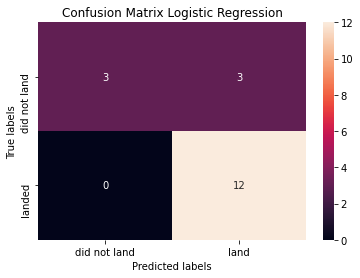

In [17]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat,'Logistic Regression')

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [18]:
parameters = {
    'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
    'C': np.logspace(-3, 3, 5),
    'gamma':np.logspace(-3, 3, 5)
}

svm = SVC()

In [19]:
grid_svc = GridSearchCV(
    svm,
    parameters,
    cv=10
)

svm_cv = grid_svc.fit(X_train, Y_train)

In [20]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [21]:
print(f'SVM score: {svm_cv.score(X_train, Y_train)}')

SVM score: 0.8888888888888888


We can plot the confusion matrix


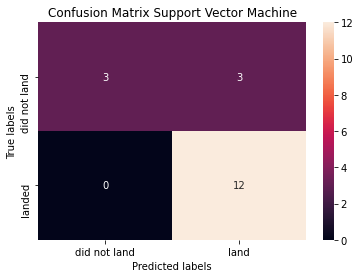

In [22]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat,'Support Vector Machine')

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [23]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2*n for n in range(1,10)],
    'max_features': ['sqrt'],    # custom code; original code deprecated: ('auto'): 'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    # 'random_state': [0]    # custom code
}

tree = DecisionTreeClassifier()

In [24]:
grid_tree = GridSearchCV(
    tree,
    parameters,
    cv=10
)

tree_cv = grid_tree.fit(X_train, Y_train)

In [25]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8767857142857143


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [26]:
print(f'Tree score: {tree_cv.score(X_train, Y_train)}')

Tree score: 0.9027777777777778


We can plot the confusion matrix


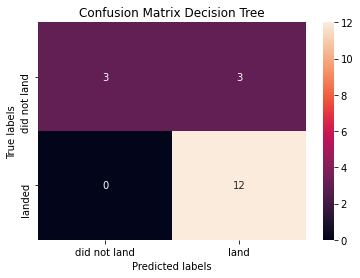

In [27]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat,'Decision Tree')

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [28]:
parameters = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2]}

KNN = KNeighborsClassifier()

In [29]:
grid_knn = GridSearchCV(
    KNN,
    parameters,
    cv=10
)

knn_cv = grid_knn.fit(X_train, Y_train)

In [30]:
print("tuned hpyerparameters :(best parameters) ", knn_cv.best_params_)
print("accuracy :", knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [31]:
print(f'KNN score: {knn_cv.score(X_train, Y_train)}')

KNN score: 0.8611111111111112


We can plot the confusion matrix


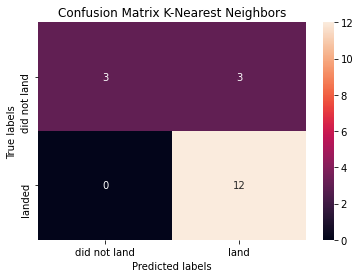

In [32]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat,'K-Nearest Neighbors')

## TASK  12


Find the method performs best:


In [33]:
print(f'\n \
        Logistic Regression:\n \
        {logreg_cv.best_score_:.2f}\n \
        {logreg_cv.score(X_test, Y_test):.4f}\n \n \
        SVM:\n \
        {svm_cv.best_score_:.2f}\n \
        {svm_cv.score(X_train, Y_train):.4f} \n \n \
        Tree:\n \
        {tree_cv.best_score_:.2f}\n \
        {tree_cv.score(X_train, Y_train):.4f}\n \n \
        KNN:\n \
        {knn_cv.best_score_:.2f}\n \
        {knn_cv.score(X_train, Y_train):.4f}\n \n \
        ')


         Logistic Regression:
         0.85
         0.8333
 
         SVM:
         0.85
         0.8889 
 
         Tree:
         0.88
         0.9028
 
         KNN:
         0.85
         0.8611
 
         


In [34]:
# custom cell

data = {
    'methods': [
        'LR',
        'SVM',
        'Tree',
        'KNN'
    ],
    'accuracy': [
        logreg_cv.score(X_test, Y_test),
        svm_cv.score(X_train, Y_train),
        tree_cv.score(X_train, Y_train),
        knn_cv.score(X_train, Y_train)
    ],
    'best score': [
        logreg_cv.best_score_,
        svm_cv.best_score_,
        tree_cv.best_score_,
        knn_cv.best_score_
    ]
}

model_performance = pd.DataFrame(data)

model_performance.sort_values(
    by='best score',
    ascending=False,
    inplace=True
)

model_performance

,methods,accuracy,best score
2,Tree,0.902778,0.876786
3,KNN,0.861111,0.848214
1,SVM,0.888889,0.848214
0,LR,0.833333,0.846429


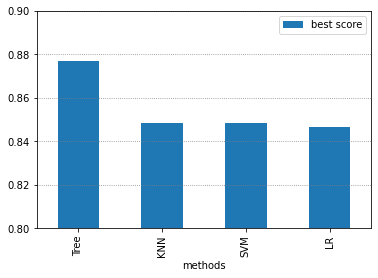

In [35]:
# custom cell
"""
model_performance.plot.barh(
    x='methods',
    y='accuracy'
)

plt.savefig('s43-model_accuracy.png', bbox_inches='tight', dpi = 100, transparent=True)"""


# plot grouped bar chart
model_performance.plot(
    x='methods',
    y='best score',
    kind='bar',
    stacked=False,
    # title=''
)

plt.ylim(bottom=.8, top=.9)
plt.grid(axis='y', color = 'gray', linestyle = ':')
plt.savefig('s43-model_accuracy.png', bbox_inches='tight', dpi = 100, transparent=True)

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
